In [1]:
using SeisIO, SeisNoise, JLD2, Plots, Dates, ProgressMeter, Measures
using SeisMonitoring: assemble_corrdata
using PyPlot
pyplot()

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/Users/kokubo/.julia/packages/Plots/MzlNY/src/backends/hdf5.jl", 36, UndefVarError(:Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000010de978cf, Ptr{Nothing} @0x000000010df4123f, Ptr{Nothing} @0x000000010df423eb, Ptr{Nothing} @0x000000010df40956, Ptr{Nothing} @0x000000010df40f4c, Base.InterpreterIP in top-level CodeInfo for Plots._hdf5_implementation at statement 4, Ptr{Nothing} @0x000000010df5bfcf, Ptr{Nothing} @0x000000010df5c165, Ptr{Nothing} @0x000000010df5bd72, Ptr{Nothing} @0x000000010df5bd72, Ptr{Nothing} @0x000000010df5d045, Ptr{Nothing} @0x0000000125bf0d9a, Ptr{Nothing} @0x000000010df28f50, Ptr{Nothing} @0x0000000125cb28b5, Ptr{Nothing} @0x0000000125820bb5, Ptr{Nothing} @0x000000010df28f50, Ptr{Nothing} @0x000000010df35d3a, Ptr{Nothing} @0x000000010f4ee0ca, Ptr{Nothing} @0x000000010df28f50, Ptr{Nothing} @0x000000010df4240f, Ptr{Nothing} @0x000000010df40956, Ptr{Nothing} @0x00000001

Plots.PyPlotBackend()

In [2]:
rc("font",family ="Arial",size=12) 
rc("xtick", direction = "in")
rc("xtick.major", size = 5, width=0.5)
rc("xtick.minor", size = 2, width=1, visible=true)

rc("ytick", direction = "in")
rc("ytick.major", size = 5, width=0.5)
rc("ytick.minor", size = 2, width=1, visible=true)

In [3]:
fi_stachanpair = "BP.EADB-BP.LCCB-11"
fi = jldopen("../data/$(fi_stachanpair).jld2", "r")
starttime = DateTime("2006-01-01T00:00:00")
endtime = DateTime("2010-01-01T00:00:00")
frequency_key = "0.9-1.2"
Craw, CorrData_Buffer = assemble_corrdata(fi,starttime,endtime,frequency_key, MAX_MEM_USE=2.0)

(CorrData with 1379 Corrs
      NAME: "BP.EADB-BP.LCCB-11"               
        ID: "2006-01-01"                       
       LOC: 35.8952 N, -120.423 E, 224.0 m
      COMP: "11"                               
   ROTATED: false                              
 CORR_TYPE: "CC"                               
        FS: 20.0
      GAIN: 1.0
   FREQMIN: 0.9
   FREQMAX: 1.2
    CC_LEN: 3600.0
   CC_STEP: 1800.0
  WHITENED: false                              
 TIME_NORM: ""                                 
      RESP: a0 1.0, f0 1.0, 1z, 1p
      MISC: 11 entries                         
     NOTES: 14 entries                         
      DIST: 12.528
       AZI: 318.74
       BAZ: 138.686
    MAXLAG: 100.0
         T: 2006-01-01T00:30:00                …
      CORR: 4001×1379 Matrix{Float32}          
, Dict{Any, Any}("2008-06-04T00:00:00--2008-06-05T00:00:00/0.9-1.2" => CorrData with 1 Corrs
      NAME: "BP.EADB-BP.LCCB-11"               
        ID: "2008-06-04"                       

In [4]:
length(CorrData_Buffer)

1379

In [5]:
C.misc

LoadError: UndefVarError: C not defined

In [6]:
# Assemble all corr data
C = CorrData()
C.corr = zeros(Float32, 4001, 0)

@showprogress 1 "computing: " for key in sort(collect(keys(CorrData_Buffer)))
    if isempty(C.id)
        # initialize corrdata
        C = CorrData_Buffer[key]
        C.t = zeros(Float64, 0)
        C.corr = zeros(Float32, 4001, 0)
    end
    if isempty(CorrData_Buffer[key].t); continue; end
    C.corr = hcat(C.corr, CorrData_Buffer[key].corr)
    push!(C.t, CorrData_Buffer[key].t[1])
end

computing: 100%|████████████████████████████████████████| Time: 0:00:13


In [7]:
lags = -C.maxlag:1/C.fs:C.maxlag
times = Dates.format.(Dates.unix2datetime.(C.t),"yyyy/m")
Cstack = stack(C,allstack=true)

CorrData with 1 Corrs
      NAME: "BP.EADB-BP.LCCB-11"               
        ID: "2006-01-01"                       
       LOC: 35.8952 N, -120.423 E, 224.0 m
      COMP: "11"                               
   ROTATED: false                              
 CORR_TYPE: "CC"                               
        FS: 20.0
      GAIN: 1.0
   FREQMIN: 0.9
   FREQMAX: 1.2
    CC_LEN: 3600.0
   CC_STEP: 1800.0
  WHITENED: false                              
 TIME_NORM: ""                                 
      RESP: a0 1.0, f0 1.0, 1z, 1p
      MISC: 10 entries                         
     NOTES: 14 entries                         
      DIST: 12.528
       AZI: 318.74
       BAZ: 138.686
    MAXLAG: 100.0
         T: 2006-01-02T00:00:00                …
      CORR: 4001×1 Matrix{Float32}             


In [8]:
# Normalize with its max amplitude
abs_max!(C)

In [9]:
yticks = 1:length(times)
yticklabels = times

# find 1st time window of each year
ytickids = []
ystart = Dates.value(Year(starttime))
for i in yticks
    if ystart == parse(Int, split(yticklabels[i], "/")[1])
        push!(ytickids, i)
        ystart = ystart+1
    end
end

In [10]:
coda_init_factor = 2.0
max_coda_length = 40.0
vel = 1.0 #[km/s]
ci = [-coda_init_factor*C.dist/vel, coda_init_factor*C.dist/vel] 
ce = [-max_coda_length , max_coda_length ] 

2-element Vector{Float64}:
 -40.0
  40.0

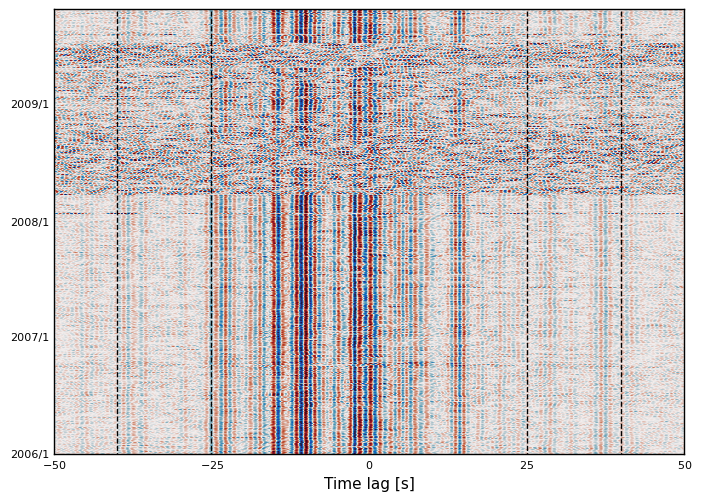

In [11]:
Plots.heatmap(lags,yticks, C.corr', dims=1,c=:balance,legend=:none, framestyle = :box, margin = 15mm,
    xlims = (-50, 50),
    yticks=(yticks[ytickids], yticklabels[ytickids]))

vline!(ci, linestyle=:dash, linecolor=:black)
vline!(ce, linestyle=:dash, linecolor=:black)
plot!(size=(800,600))
xlabel!("Time lag [s]")
Plots.savefig("ccf_$(fi_stachanpair).png")

# Check the time stamp in the plot
Here we check if the ccf image has correct timestamps by comparing it with the individual CCF waveform.

In [12]:
# T1:2007/1/1
T1ind = findall(x -> (x== Date(2007, 6, 1)), Date.(u2d.(Craw.t)))[1]

# T1:2008/8/1
T2ind = findall(x -> (x== Date(2009, 6, 1)), Date.(u2d.(Craw.t)))[1]

1166

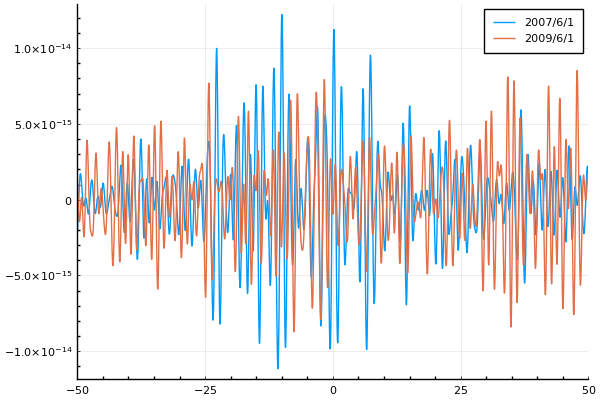

In [13]:
corr1 = Craw.corr[:, T1ind]
corr2 = Craw.corr[:, T2ind]

Plots.plot(lags, corr1, label="2007/6/1")
Plots.plot!(lags, corr2, label="2009/6/1")
xlims!(-50, 50)


The figure above shows that the 2007 shows clear peaks in CCF, while no coherent phases on 2009, which is consistent to the CCF image.

## plot reference


In [14]:
# find 1st time window of each year
yrefids = []
for i in yticks
    if (2002 < parse(Int, split(yticklabels[i], "/")[1])) & (2020 >= parse(Int, split(yticklabels[i], "/")[1]))
        push!(yrefids, i)
    end
end

In [15]:
Cstack = deepcopy(C)
Cstack.t = C.t[yrefids]
Cstack.corr = C.corr[:, yrefids]
stack!(Cstack,allstack=true)

CorrData with 1 Corrs
      NAME: "BP.EADB-BP.LCCB-11"               
        ID: "2006-01-01"                       
       LOC: 35.8952 N, -120.423 E, 224.0 m
      COMP: "11"                               
   ROTATED: false                              
 CORR_TYPE: "CC"                               
        FS: 20.0
      GAIN: 1.0
   FREQMIN: 0.9
   FREQMAX: 1.2
    CC_LEN: 3600.0
   CC_STEP: 1800.0
  WHITENED: false                              
 TIME_NORM: ""                                 
      RESP: a0 1.0, f0 1.0, 1z, 1p
      MISC: 10 entries                         
     NOTES: 14 entries                         
      DIST: 12.528
       AZI: 318.74
       BAZ: 138.686
    MAXLAG: 100.0
         T: 2006-01-02T00:00:00                …
      CORR: 4001×1 Matrix{Float32}             


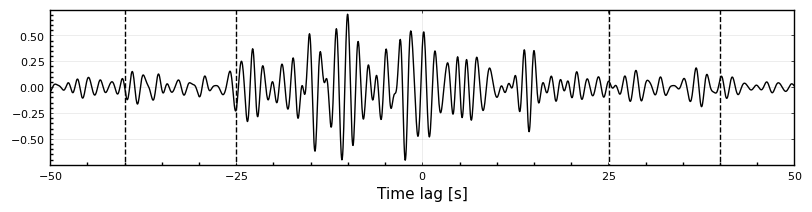

In [16]:
Plots.plot(lags, Cstack.corr, linecolor=:black, xlims=(-50, 50), framestyle = :box, legend=false)
vline!(ci, linestyle=:dash, linecolor=:black)
vline!(ce, linestyle=:dash, linecolor=:black)

plot!(size=(800,200))

xlabel!("Time lag [s]")
Plots.savefig("ccf_ref_$(fi_stachanpair).png")

In [17]:
data_corr = Dict("lags" => lags, "t"=>C.t, "corr"=>C.corr, "linstack"=>Cstack.corr)

Dict{String, AbstractArray} with 4 entries:
  "lags"     => -100.0:0.05:100.0
  "linstack" => Float32[0.0; 0.0; … ; 0.0; 0.0;;]
  "t"        => [1.13616e9, 1.13625e9, 1.13633e9, 1.13642e9, 1.13651e9, 1.13659…
  "corr"     => Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…

In [18]:
save("$(fi_stachanpair).npz", data_corr)

In [19]:
C.corr

4001×1378 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0